## Building Text Generation With LSTMs and PyTorch

Today we are going to build Text Generation With LSTMs from scratch using PyTorch.

**Below information and images are mainly collected from below articles and references:**
    
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [LSTMs and Bi-LSTM in PyTorch](https://www.scaler.com/topics/pytorch/lstm-pytorch/)

    


In [150]:
import torch
import torch.nn as nn
import string
import contractions
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Downloading the dataset

In [2]:
# Define the URL of the dataset
url = "https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv"

# Set the output filename
filename = "reddit-cleanjokes.csv"

# Send a GET request to download the dataset
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in write binary mode
    with open(filename, "wb") as f:
        # Write the content of the response to the file
        f.write(response.content)

    print(f"Dataset downloaded successfully and saved as {filename}")
else:
    print(f"Download failed with status code: {response.status_code}")


Dataset downloaded successfully and saved as reddit-cleanjokes.csv


## Custom Text Dataset

This code defines a custom PyTorch `Dataset` class for text data:

- **Loads and cleans jokes:** Reads jokes from CSV, concatenates, removes contractions, and eliminates punctuation.
- **Builds vocabulary:** Creates unique words list, maps words to indexes and vice versa.
- **Defines dataset length:** Considers sequence length for accurate data size.
- **Provides data access:** Returns sequences of 4 words and their next word as targets. 

In [129]:
# custom dataset class to load the data examples
class Dataset(Dataset):
    def __init__(self):
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('reddit-cleanjokes.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        # Removing Contractions
        text = contractions.fix(text).split(' ')
        text = self.data_cleaning(text)
        return text
    
    def data_cleaning(self, text):
        # removing punctations
        PUNCT_TO_REMOVE = string.punctuation
        empty_table = str.maketrans('', '', PUNCT_TO_REMOVE)
        no_punc_text = [word.translate(empty_table) for word in text]
        return no_punc_text
        

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)


    # returns the length of the dataset
    def __len__(self):
        return len(self.words_indexes) - 4

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+4]),
            torch.tensor(self.words_indexes[index+1:index+4+1]))


# Building The Model

### LSTM Gates

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture designed to overcome the vanishing gradient problem and effectively capture long-term dependencies in sequential data.

In an LSTM unit, there are three main gates:

1. **Forget Gate:**
   - The forget gate determines what information from the previous cell state \( C_{t-1} \) should be discarded or forgotten.
   - It takes input \( x_t \) (current input) and \( h_{t-1} \) (previous hidden state) and produces a forget gate vector \( f_t \) through a sigmoid activation function.
   - The forget gate's output is multiplied element-wise with the previous cell state \( C_{t-1} \), resulting in the forgotten information.

2. **Input Gate:**
   - The input gate determines which new information should be stored in the cell state.
   - It consists of two sub-components:
     - **Input Gate:** Determines which values to update.
     - **Candidate Cell State:** Generates new candidate values to be added to the cell state.
   - Both components take \( x_t \) and \( h_{t-1} \) as input and produce vectors \( i_t \) and \( \tilde{C}_t \) (candidate cell state) through sigmoid and tanh activation functions, respectively.
   - The input gate's output is the element-wise product of \( i_t \) and \( \tilde{C}_t \), representing the new candidate values.

3. **Output Gate:**
   - The output gate determines the next hidden state \( h_t \) based on the current input and the updated cell state.
   - It takes \( x_t \) and \( h_{t-1} \) as input and produces an output gate vector \( o_t \) through a sigmoid activation function.
   - The current cell state \( C_t \) is passed through a tanh activation function to squash the values between -1 and 1.
   - The output gate's output is the element-wise product of \( o_t \) and the squashed cell state, resulting in the next hidden state \( h_t \).

These gates collectively enable LSTMs to control the flow of information over time, allowing them to learn and remember long-term dependencies in sequential data more effectively than traditional RNNs.


<img src='/images/lstms_gates.png'>

In [130]:
class Model(nn.Module):
    def __init__(self, dataset, input_size, embed_dim, layer_dim):
        super(Model, self).__init__()
        self.input_size = input_size
        self.embed_dim = embed_dim
        self.layer_dim = layer_dim
        n_vocab = len(dataset.uniq_words)

        self.embeding = nn.Embedding(num_embeddings=n_vocab,
                                     embedding_dim=self.embed_dim)
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.input_size,
                            num_layers=self.layer_dim,
                            dropout=0.1)
        self.fc = nn.Linear(self.input_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embeding(x)
        output, state = self.lstm(embed, prev_state) # -> output, (hidden_state, cell_state)
        logits = self.fc(output)
        return logits, state
    
    def init_state(self, sequence_length):
        return (torch.randn(self.layer_dim, sequence_length, self.input_size).cuda(),
                torch.randn(self.layer_dim, sequence_length, self.input_size).cuda())

INPUT_SIZE = 128
EMBED_SIZE = 128
LAYER_DIM = 3

dataset = Dataset()
model = Model(dataset, INPUT_SIZE, EMBED_SIZE, LAYER_DIM).to(device)

In [131]:
dataloader = DataLoader(dataset, batch_size=128)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [132]:
x, y = next(iter(dataloader))
x[0], y[0]

(tensor([  2,   8,   0, 264]), tensor([  8,   0, 264,  19]))

In [133]:
# Understanding the model inputs and labels
train_words = [dataset.index_to_word[word.item()] for word in x[0]]
label = [dataset.index_to_word[word.item()] for word in y[0]]
train_words, label

(['What', 'did', 'the', 'bartender'], ['did', 'the', 'bartender', 'say'])

In [134]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               hidden_state: torch.tensor,
               cell_state: torch.tensor):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    #print('before batch start')
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        #print(f'X shape {X.shape}')
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred, (hidden_state, cell_state) = model(X, (hidden_state, cell_state))
        #print(f'y_pred  shape is {y_pred.shape} and y shape is {y.shape}')
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred.transpose(1, 2), y)
        
        #print(f'y_pred after shape is {y_pred.transpose(1, 2).shape} and y shape is {y.shape}')
        train_loss += loss.item() 

        hidden_state, cell_state = hidden_state.detach(), cell_state.detach()
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()
        #print(batch)

    # scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    return train_loss

In [136]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 30):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        (hidden_state, cell_state) = model.init_state(4)

        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                hidden_state=hidden_state,
                                cell_state=cell_state)

        
        # 4. Print out what's happening
        if epoch % 10 == 0 or epoch+1 == epochs:
            print(
                    f"Epoch: {epoch+1} | "
                    f"train_loss: {train_loss:.4f} | "
            )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
    # 6. Return the filled results at the end of the epochs
    return results

In [137]:
model_results = train(model, dataloader, optimizer, loss_fn, epochs=100)

  1%|          | 1/100 [00:01<02:51,  1.73s/it]

Epoch: 1 | train_loss: 7.1190 | 


 11%|█         | 11/100 [00:15<02:02,  1.38s/it]

Epoch: 11 | train_loss: 4.4044 | 


 21%|██        | 21/100 [00:29<01:48,  1.37s/it]

Epoch: 21 | train_loss: 3.1526 | 


 31%|███       | 31/100 [00:43<01:37,  1.41s/it]

Epoch: 31 | train_loss: 2.2032 | 


 41%|████      | 41/100 [00:57<01:20,  1.36s/it]

Epoch: 41 | train_loss: 1.5167 | 


 51%|█████     | 51/100 [01:11<01:09,  1.42s/it]

Epoch: 51 | train_loss: 1.0517 | 


 61%|██████    | 61/100 [01:26<00:55,  1.43s/it]

Epoch: 61 | train_loss: 0.6756 | 


 71%|███████   | 71/100 [01:39<00:39,  1.36s/it]

Epoch: 71 | train_loss: 0.4904 | 


 81%|████████  | 81/100 [01:53<00:26,  1.37s/it]

Epoch: 81 | train_loss: 0.3954 | 


 91%|█████████ | 91/100 [02:07<00:12,  1.37s/it]

Epoch: 91 | train_loss: 0.2991 | 


100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

Epoch: 100 | train_loss: 0.2294 | 


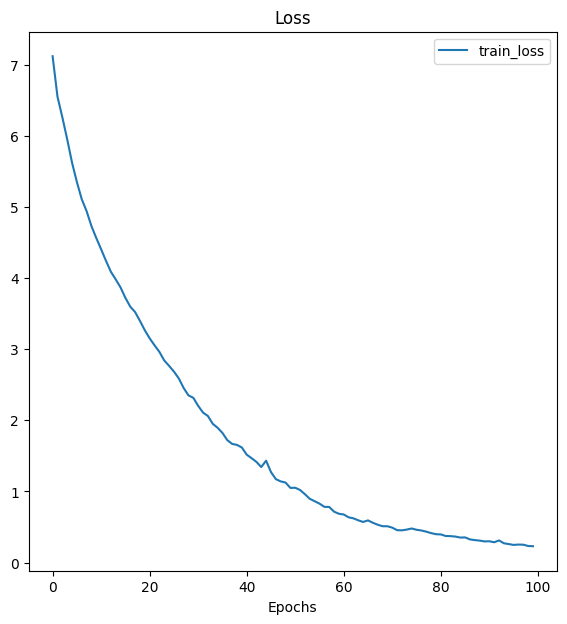

In [138]:
def plot_loss_curves(results):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    #test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    #accuracy = results['train_acc']
    #test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    # plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    # plt.subplot(1, 2, 2)
    # plt.plot(epochs, accuracy, label='train_accuracy')
    # plt.plot(epochs, test_accuracy, label='test_accuracy')
    # plt.title('Accuracy')
    # plt.xlabel('Epochs')
    # plt.legend();

plot_loss_curves(model_results)

Let's delve deeper into why random sampling with softmax probabilities is preferred for text generation compared to `argmax`, with examples for both approaches.

**1. Argmax and its Limitations:**

Imagine a scenario where your model predicts the following probabilities for the next word after "why":

- the: 0.95
- is: 0.02
- a: 0.01
- other: 0.02

Using `argmax` in this case would always pick "the" as it has the highest probability (0.95). This leads to repetitive and predictable outputs:

```
why the the the the the ... (repeated "the")
```

The model's knowledge about other possible continuations ("is," "a," or something else) gets entirely ignored.

**2. Random Sampling with Softmax Probabilities:**

Random sampling with softmax probabilities addresses this limitation by leveraging both the model's predictions and a random element. Here's how it works:

  a. **Softmax Transformation:**
     The model's raw logits for each word are converted into probabilities using the softmax function. This transforms the logits into a distribution where the sum of all probabilities is 1.

  b. **Probability Distribution:**
     In the example above, the softmax probabilities might look like this:

     - the: 0.8 (rounded from 0.95 for clarity)
     - is: 0.02
     - a: 0.01
     - other: 0.02

  c. **Random Choice with Probabilities:**
     Instead of blindly picking the highest value, a word is chosen **randomly** based on its probability in the softmax distribution.

  d. **Benefits:**
     - Words with higher probabilities are more likely to be chosen, reflecting the model's knowledge.
     - Randomness allows for choosing less likely words, leading to more diverse and interesting outputs.

**Example with Random Sampling:**

In our example with probabilities (0.8 for "the", 0.02 for others), random sampling might choose:

- **Iteration 1:** "the" (higher probability)
- **Iteration 2:** "is" (less likely, but possible)
- **Iteration 3:** "a" (possible, but less likely)

This results in a more varied sequence compared to using `argmax`.

**Key Points:**

- Random sampling with softmax probabilities allows the model to influence word choice while introducing randomness for creativity.
- While a high probability word might be chosen more often, less likely words can still be selected, leading to diverse outputs.

**In summary:**

- `argmax` is too deterministic, leading to repetitive and predictable text generation.
- Random sampling with softmax probabilities balances model knowledge with randomness, producing more interesting and varied outputs.


In [146]:
def predict(dataset, model, text, next_words=10):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]]).cuda() # stores the index of every word we gave to the model # ['why', 'you', 'are'] -> [231, 21, 345]
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1] # reduce dimension
        #print(last_word_logits[0:10])
        last_word_logits = last_word_logits.to(torch.float64).cpu() # convert to float64 to sum the preds to 1
        p = torch.softmax(last_word_logits, dim=0).detach().cpu()#.numpy()
        #word_index = p.argmax(dim=0)
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words



print(predict(dataset, model, text='i like your'))


['i', 'like', 'your', 'think', 'when', 'you', 'want', 'to', 'try', 'a', 'TV', 'on', 'reverse']


# Draft Cells

In [ ]:
len(test[1])
test2 = torch.softmax(test[1], dim=0)
print(test2.sum())

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
# reading the dataset
train_df = pd.read_csv('reddit-cleanjokes.csv')
train_df['Joke'].head()


0    What did the bartender say to the jumper cable...
1    Don't you hate jokes about German sausage? The...
2    Two artists had an art contest... It ended in ...
3    Why did the chicken cross the playground? To g...
4     What gun do you use to hunt a moose? A moosecut!
Name: Joke, dtype: object

In [153]:
text = train_df['Joke'].str.cat(sep=' ')
text = contractions.fix(text)
print(text[0:100])
filtered_text = text.split(' ')
print(filtered_text[0:8])
print(len(filtered_text)) # all words
PUNCT_TO_REMOVE = string.punctuation
empty_table = str.maketrans('', '', PUNCT_TO_REMOVE)
cleaned_text = [word.translate(empty_table) for word in filtered_text ]
print(len(cleaned_text)) # all words
word_counts = Counter(cleaned_text)
print(len(word_counts)) # unique words
print(sorted(word_counts, key=word_counts.get, reverse=True)[0:10])



What did the bartender say to the jumper cables? You better not try to start anything. Do not you ha
['What', 'did', 'the', 'bartender', 'say', 'to', 'the', 'jumper']
24517
24517
5175
['the', 'a', 'What', 'you', 'to', 'I', 'do', 'is', 'did', 'of']


In [ ]:
import string

text = 'I had such high hopes! for this dress size or (my usual size) to work for me.'
PUNCT_TO_REMOVE = string.punctuation

# Create a translation table with empty replacements for punctuation
empty_table = str.maketrans('', '', PUNCT_TO_REMOVE)
ans = text.translate(empty_table)
print(ans)


I had such high hopes for this dress size or my usual size to work for me
